# Fine Grained Analysis with ResNet34

### Importing Required Libraries

In [ ]:
# %reload_ext autoreload
# %autoreload 2
# %matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import random
import matplotlib.pyplot as plt
import shutil
import os
import PIL
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.optim as optim
import torch.utils.data as data
from torch.nn.modules.pooling import MaxPool2d
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import copy
import random
import time
# Needed for Nakul's code
#os.add_dll_directory('C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDNN\\v8.4\\bin') 
# load opencv after the os add dll directory
import cv2 # (uses custom opencv build for NVIDIA GPU)

## Data Preprocessing  
- Downloading and extracting custom datasets  
- Loading custom datasets  
- Calculating the mean and std for normalization on custom datasets  
- Loading transforms to augment and normalize our data  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/Final_Project.zip  > /dev/null

### Convert to R Channel

In [ ]:
'''
folders = []
folder_paths = []
data = []
data_paths = []

for folder in os.listdir(train_path):
  folders.append(folder)
  local_path = train_path + "/"+str(folder)
  folder_paths.append(local_path)
  for filename in os.listdir(local_path):
    data.append(filename)
    data_path = local_path + "/"+str(filename)
    data_paths.append(data_path)
'''

'\nfolders = []\nfolder_paths = []\ndata = []\ndata_paths = []\n\nfor folder in os.listdir(train_path):\n  folders.append(folder)\n  local_path = train_path + "/"+str(folder)\n  folder_paths.append(local_path)\n  for filename in os.listdir(local_path):\n    data.append(filename)\n    data_path = local_path + "/"+str(filename)\n    data_paths.append(data_path)\n'

In [ ]:
'''
#Convert images to just R Channel
for x in data_paths:
  raw = cv2.imread(str(x))
  org = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
  red_channel = org.copy()
  red_channel[:,:, 0] = 0
  red_channel[:,:, 1] = 0
  cv2.imwrite(x, red_channel)
'''

'\n#Convert images to just R Channel\nfor x in data_paths:\n  raw = cv2.imread(str(x))\n  org = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)\n  red_channel = org.copy()\n  red_channel[:,:, 0] = 0\n  red_channel[:,:, 1] = 0\n  cv2.imwrite(x, red_channel)\n'

In [ ]:
'''
folders = []
folder_paths = []
data = []
data_paths = []

for folder in os.listdir(test_path):
  folders.append(folder)
  local_path = test_path + "/"+str(folder)
  folder_paths.append(local_path)
  for filename in os.listdir(local_path):
    data.append(filename)
    data_path = local_path + "/"+str(filename)
    data_paths.append(data_path)
'''

'\nfolders = []\nfolder_paths = []\ndata = []\ndata_paths = []\n\nfor folder in os.listdir(test_path):\n  folders.append(folder)\n  local_path = test_path + "/"+str(folder)\n  folder_paths.append(local_path)\n  for filename in os.listdir(local_path):\n    data.append(filename)\n    data_path = local_path + "/"+str(filename)\n    data_paths.append(data_path)\n'

In [ ]:
'''
#Convert images to just R Channel
for x in data_paths:
  raw = cv2.imread(str(x))
  org = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
  red_channel = org.copy()
  red_channel[:,:, 0] = 0
  red_channel[:,:, 1] = 0
  cv2.imwrite(x, red_channel)
'''

'\n#Convert images to just R Channel\nfor x in data_paths:\n  raw = cv2.imread(str(x))\n  org = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)\n  red_channel = org.copy()\n  red_channel[:,:, 0] = 0\n  red_channel[:,:, 1] = 0\n  cv2.imwrite(x, red_channel)\n'

In [ ]:
#len(data_paths)

In [ ]:
train_path = 'Final_Project/blue_train/'

test_path = 'Final_Project/blue_test/'

In [ ]:
image_data = torchvision.datasets.ImageFolder(
    root = train_path,
    transform = transforms.Compose([
    transforms.ToTensor()]))


image_loader = torch.utils.data.DataLoader(
    image_data, 
    batch_size= 10,
    shuffle=True
)

####### COMPUTE MEAN / STD
mean = torch.tensor([0.40843535, 0.40843535,0.40843535])
std = torch.tensor([0.1171599, 0.1171599,0.1171599])
'''
# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for groups in tqdm(image_loader):
    for inputs in groups:
      psum    += inputs.sum()
      psum_sq += (inputs ** 2).sum()
'''


'\n# placeholders\npsum    = torch.tensor([0.0, 0.0, 0.0])\npsum_sq = torch.tensor([0.0, 0.0, 0.0])\n\n# loop through images\nfor groups in tqdm(image_loader):\n    for inputs in groups:\n      psum    += inputs.sum()\n      psum_sq += (inputs ** 2).sum()\n'

In [ ]:
'''
# pixel count
count = 2160 * 64 * 64

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))
'''

"\n# pixel count\ncount = 2160 * 64 * 64\n\n# mean and std\ntotal_mean = psum / count\ntotal_var  = (psum_sq / count) - (total_mean ** 2)\ntotal_std  = torch.sqrt(total_var)\n\n# output\nprint('mean: '  + str(total_mean))\nprint('std:  '  + str(total_std))\n"

### Define Model(AlexNet)
**More Information**

In [ ]:
from torchvision.transforms.transforms import CenterCrop


class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')


means = [0.40843535, 0.40843535,0.40843535]
stds = [0.1171599, 0.1171599,0.1171599]

transform = torchvision.transforms.Compose(
    [
     SquarePad(),
     torchvision.transforms.RandomHorizontalFlip(p=0.5),
     torchvision.transforms.RandomVerticalFlip(p=0.5),
     torchvision.transforms.Resize(32),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(
         mean=means,
         std=stds
     )
    ]
)

train_data = torchvision.datasets.ImageFolder(
    root = train_path+ '/',
    transform = transform)


train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size= 32,
    shuffle=True,
    num_workers=0
)

test_data = torchvision.datasets.ImageFolder(
    root = test_path+ '/',
    transform = transform)


test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size= 32,
    shuffle=True,
    num_workers=0
)

In [ ]:
def normalize_image(image): 
  image_min = image.min() 
  image_max = image.max() 
  image.clamp_(min = image_min, max=image_max) 
  image.add_(-image_min).div_(image_max-image_min + 1e-5) 
  return image

In [ ]:
BATCH_SIZE = 256

train_iterator = torch.utils.data.DataLoader(train_data,shuffle = True,batch_size = BATCH_SIZE)
test_iterator = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE)

In [ ]:
class AlexNet(nn.Module):
  def __init__(self, output_dim):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3,64,3,2,1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True),
        nn.Conv2d(64,192,3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True),
        nn.Conv2d(192,384,3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384,256,3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256,256,3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True)
    )

    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(256 * 2 * 2, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096,output_dim)
    )

  def forward(self, x):
    x = self.features(x)
    h = x.view(x.shape[0],-1)
    x = self.classifier(h)
    return x, h

In [ ]:
OUTPUT_DIM = 10

model = AlexNet(OUTPUT_DIM)

In [ ]:
def initialize_parameters(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
    nn.init.constant_(m.bias.data, 0)
  elif isinstance(0, nn.Linear):
    nn.init.xavier_normal_(m.weight.data,gain=nn.init.calculate_gain('relu'))
    nn.init.constant_(m.bias.data, 0)

In [ ]:
model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
class LRFinder:
  def __init__(self, model, optimizer, criterion, device):
    self.optimizer = optimizer
    self.model = model
    self.criterion = criterion
    self.device = device
    torch.save(model.state_dict(), 'init_params.pt')
  def range_test(self, iterator, end_lr = 10, num_iter = 100, smooth_f = 0.05, diverge_th = 5):
    lrs = []
    losses = []
    best_loss = float('inf')
    lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
    iterator = IteratorWrapper(iterator)
    for iteration in range(num_iter):
      loss = self._train_batch(iterator)
      lrs.append(lr_scheduler.get_last_lr()[0])
      lr_scheduler.step()

      if iteration > 0:
        loss = smooth_f * loss + (1- smooth_f) * losses[-1]

      if loss < best_loss:
        best_loss = loss
      losses.append(loss)

      if loss > diverge_th * best_loss:
        print('Stopping early, the loss has diverged')
        break
      
    model.load_state_dict(torch.load('init_params.pt'))
    return lrs, losses

  def _train_batch(self, iterator):
    self.model.train()
    self.optimizer.zero_grad()
    x, y = iterator.get_batch()
    x = x.to(self.device)
    y = y.to(self.device)

    y_pred, _ = self.model(x)
    loss = self.criterion(y_pred, y)
    loss.backward()
    self.optimizer.step()
    return loss.item()

class ExponentialLR(_LRScheduler):

  def __init__(self, optimizer, end_lr, num_iter, last_epoch = -1):
    self.end_lr = end_lr
    self.num_iter = num_iter
    super(ExponentialLR, self).__init__(optimizer, last_epoch)

  def get_lr(self):
    curr_iter = self.last_epoch
    r = curr_iter / self.num_iter
    return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


class IteratorWrapper:
  def __init__(self, iterator):
    self.iterator = iterator
    self._iterator = iter(iterator)

  def __next__(self):
    try:
      inputs, labels = next(self._iterator)
    except StopIteration:
      self._iterator = iter(self.iterator)
      inputs, labels, *_ = next(self._iterator)
    return inputs, labels

  def get_batch(self):
    return next(self)


In [ ]:
START_LR = 1e-7
optimizer = optim.Adam(model.parameters(), lr=START_LR)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
END_LR = 100
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [ ]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):

  if skip_end == 0:
    lrs = lrs[skip_start:]
    losses = losses[skip_start:]
  else:
    lrs = lrs[skip_start:-skip_end]
    losses = losses[skip_start:-skip_end]
  fig = plt.figure(figsize = (7.5,4.5), dpi = 150)
  ax = fig.add_subplot(1,1,1)
  ax.plot(lrs, losses)
  ax.set_xscale('log')
  ax.set_xlabel('Learning rate')
  ax.set_ylabel('Loss')
  ax.grid(True, 'both', 'x', color='#666666', linestyle = '-', alpha = 0.4)
  ax.grid(True, 'both', 'y', color ='#666666', linestyle='-', alpha = 0.4)
  plt.show()

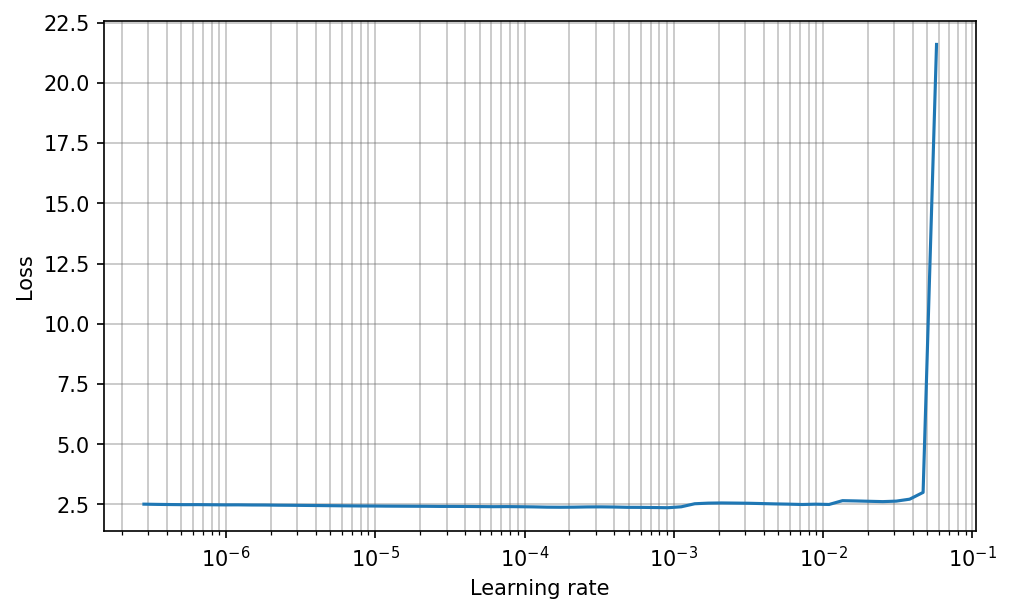

In [ ]:
plot_lr_finder(lrs, losses, skip_end=0)

In [ ]:
FOUND_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr = FOUND_LR)

In [ ]:
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x,y) in tqdm(iterator, desc="Training", leave=False):

      x = x.to(device)
      y = y.to(device)

      optimizer.zero_grad()

      y_pred, _ = model(x)

      loss = criterion(y_pred, y)

      acc = calculate_accuracy(y_pred, y)

      loss.backward()

      optimizer.step()

      epoch_loss += loss.item()
      epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):
  
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x,y) in tqdm(iterator, desc="Evaluating", leave=False):

          x = x.to(device)
          y = y.to(device)

          y_pred, _ = model(x)

          loss = criterion(y_pred, y)

          acc = calculate_accuracy(y_pred, y)

          epoch_loss += loss.item()
          epoch_acc += acc.item()
      
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time/60)
  elapsed_secs = int(elapsed_time - (elapsed_mins*60))
  return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 50
R_AlexNet_Train_Loss = []
R_AlexNet_Train_Acc = []
R_AlexNet_Test_Loss = []
R_AlexNet_Test_Acc = []

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc='Epochs'):

  start_time = time.monotonic()

  train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
  test_loss, test_acc = evaluate(model, test_loader, criterion, device)
#  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

#  if valid_loss < best_valid_loss:
#    best_valid_loss - valid_loss
#    torch.save(model.state_dict(), 'tut3-model.pt')
  
  end_time = time.monotonic()

  epoch_mins = epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}= {epoch_secs}s')
  R_AlexNet_Train_Loss.append(train_loss)
  R_AlexNet_Train_Acc.append(train_acc)
  R_AlexNet_Test_Loss.append(test_loss)
  R_AlexNet_Test_Acc.append(test_acc)
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 2.604 | Train Acc: 18.66%
	Test Loss: 2.055 | Test Acc: 22.95%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.965 | Train Acc: 23.35%
	Test Loss: 1.814 | Test Acc: 29.62%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.809 | Train Acc: 30.01%
	Test Loss: 1.711 | Test Acc: 32.72%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.717 | Train Acc: 33.59%
	Test Loss: 1.575 | Test Acc: 36.82%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.594 | Train Acc: 38.56%
	Test Loss: 1.697 | Test Acc: 40.76%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.621 | Train Acc: 38.01%
	Test Loss: 1.627 | Test Acc: 38.42%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.542 | Train Acc: 42.14%
	Test Loss: 1.634 | Test Acc: 37.05%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.527 | Train Acc: 43.29%
	Test Loss: 1.570 | Test Acc: 41.26%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.547 | Train Acc: 39.57%
	Test Loss: 1.613 | Test Acc: 40.91%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.587 | Train Acc: 39.75%
	Test Loss: 1.524 | Test Acc: 38.31%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.453 | Train Acc: 43.15%
	Test Loss: 1.473 | Test Acc: 39.92%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.464 | Train Acc: 43.20%
	Test Loss: 1.461 | Test Acc: 42.28%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.503 | Train Acc: 42.56%
	Test Loss: 1.493 | Test Acc: 42.28%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.427 | Train Acc: 44.30%
	Test Loss: 1.465 | Test Acc: 42.25%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.415 | Train Acc: 45.73%
	Test Loss: 1.642 | Test Acc: 40.18%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.412 | Train Acc: 46.05%
	Test Loss: 1.395 | Test Acc: 44.54%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.432 | Train Acc: 45.40%
	Test Loss: 1.488 | Test Acc: 45.56%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.396 | Train Acc: 46.60%
	Test Loss: 1.431 | Test Acc: 48.00%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.329 | Train Acc: 50.74%
	Test Loss: 1.551 | Test Acc: 43.36%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.361 | Train Acc: 49.45%
	Test Loss: 1.421 | Test Acc: 45.90%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.335 | Train Acc: 48.21%
	Test Loss: 1.380 | Test Acc: 48.11%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.328 | Train Acc: 49.08%
	Test Loss: 1.363 | Test Acc: 45.27%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.290 | Train Acc: 51.19%
	Test Loss: 1.283 | Test Acc: 48.45%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.304 | Train Acc: 49.45%
	Test Loss: 1.337 | Test Acc: 48.27%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.253 | Train Acc: 51.38%
	Test Loss: 1.285 | Test Acc: 48.90%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.249 | Train Acc: 51.33%
	Test Loss: 1.286 | Test Acc: 47.56%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.234 | Train Acc: 52.25%
	Test Loss: 1.238 | Test Acc: 50.26%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.204 | Train Acc: 54.14%
	Test Loss: 1.364 | Test Acc: 52.86%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.273 | Train Acc: 51.06%
	Test Loss: 1.272 | Test Acc: 53.34%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.306 | Train Acc: 50.64%
	Test Loss: 1.395 | Test Acc: 48.32%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 31 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.165 | Train Acc: 56.66%
	Test Loss: 1.228 | Test Acc: 54.28%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.171 | Train Acc: 54.83%
	Test Loss: 1.350 | Test Acc: 50.08%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 33 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.149 | Train Acc: 54.96%
	Test Loss: 1.336 | Test Acc: 49.74%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.156 | Train Acc: 55.61%
	Test Loss: 1.277 | Test Acc: 50.18%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 35 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.136 | Train Acc: 56.71%
	Test Loss: 1.331 | Test Acc: 53.73%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.148 | Train Acc: 55.65%
	Test Loss: 1.499 | Test Acc: 44.30%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 37 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.125 | Train Acc: 56.57%
	Test Loss: 1.327 | Test Acc: 48.74%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.191 | Train Acc: 54.96%
	Test Loss: 1.410 | Test Acc: 51.50%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 39 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.125 | Train Acc: 56.99%
	Test Loss: 1.246 | Test Acc: 53.39%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.060 | Train Acc: 60.52%
	Test Loss: 1.401 | Test Acc: 47.03%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 41 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.066 | Train Acc: 58.59%
	Test Loss: 1.331 | Test Acc: 48.16%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.061 | Train Acc: 59.51%
	Test Loss: 1.335 | Test Acc: 52.26%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 43 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.028 | Train Acc: 60.98%
	Test Loss: 1.172 | Test Acc: 53.86%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.051 | Train Acc: 59.56%
	Test Loss: 1.174 | Test Acc: 58.14%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 45 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.031 | Train Acc: 61.17%
	Test Loss: 1.232 | Test Acc: 55.15%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.008 | Train Acc: 60.43%
	Test Loss: 1.301 | Test Acc: 53.57%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 47 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 0.994 | Train Acc: 62.41%
	Test Loss: 1.230 | Test Acc: 56.17%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 0.995 | Train Acc: 62.32%
	Test Loss: 1.180 | Test Acc: 56.30%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 49 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 1.018 | Train Acc: 63.01%
	Test Loss: 1.284 | Test Acc: 58.32%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 50 | Epoch Time: (0, 2)= (0, 2)s
	Train Loss: 0.950 | Train Acc: 64.52%
	Test Loss: 1.252 | Test Acc: 53.26%


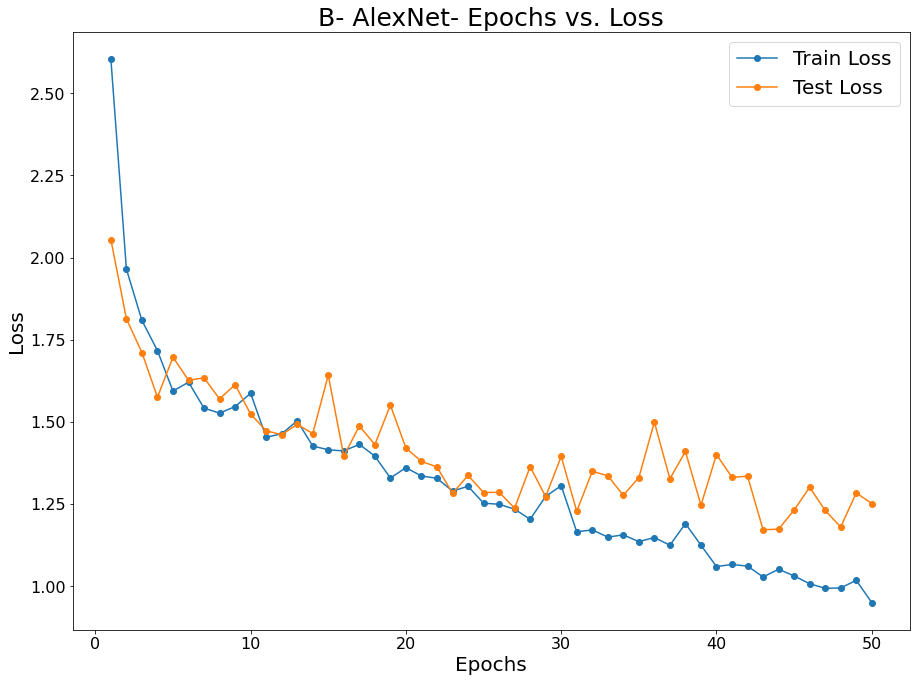

In [ ]:
from matplotlib import RcParams
myrcparams = RcParams({'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 0.0,
          'figure.facecolor': 'white',
          'font.family': ['serif'],
          'grid.color': 'white',
          'grid.linestyle': '--',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': 'round',
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direction': 'out',
          'ytick.major.size': 0.0,
          'ytick.minor.size': 0.0})

plt.style.library['seaborn-whitegrid']
RcParams.update(myrcparams)

fig, ax = plt.subplots(figsize =(15,11))

x = np.arange(1,len(R_AlexNet_Train_Loss)+1)

ax.plot(x, R_AlexNet_Train_Loss, '-o', label = "Train Loss")
ax.plot(x, R_AlexNet_Test_Loss, '-o', label = "Test Loss")

ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Loss", fontsize = 20)
ax.set_title('B- AlexNet- Epochs vs. Loss',fontsize = 25)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)
plt.savefig("B_AlexNet_Loss_vs_Epochs.jpg", dpi = 300, bbox_inches = 'tight')
plt.savefig("B_AlexNet_Loss_vs_Epochs.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()

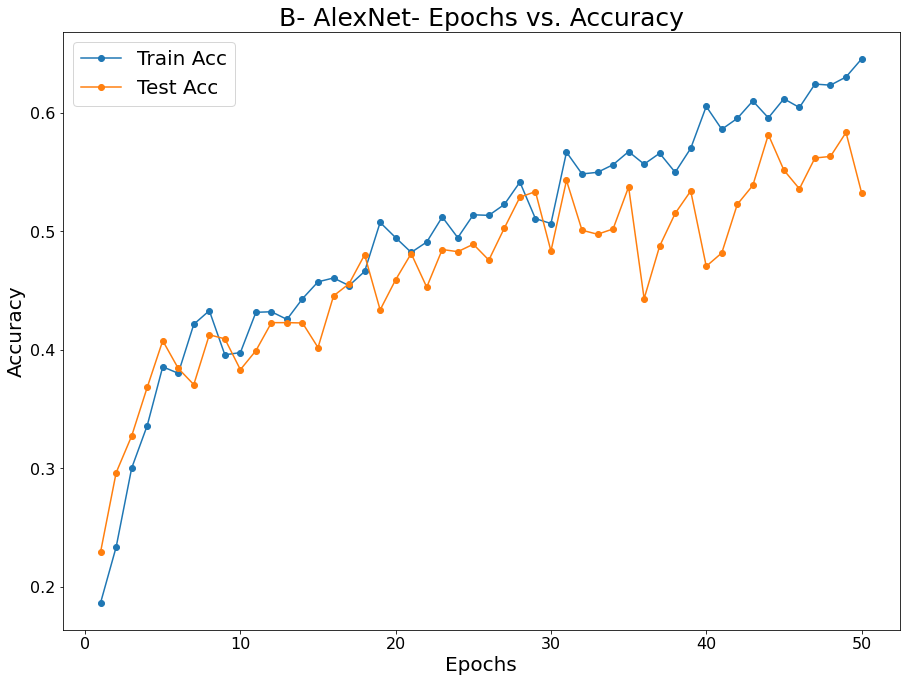

In [ ]:
fig, ax = plt.subplots(figsize =(15,11))

x = np.arange(1,len(R_AlexNet_Train_Loss)+1)

ax.plot(x, R_AlexNet_Train_Acc, '-o', label = "Train Acc")
ax.plot(x, R_AlexNet_Test_Acc, '-o', label = "Test Acc")

ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)
ax.set_title('B- AlexNet- Epochs vs. Accuracy',fontsize = 25)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)
plt.savefig("B_AlexNet_Epochs_vs_Accuracy.jpg")
plt.savefig("B_AlexNet_Epochs_vs_Accuracy.pdf")
plt.show()

In [ ]:
def get_predictions(model, iterator, device):
  model.eval()
  images =[]
  labels=[]
  probs=[]
  with torch.no_grad():
    for (x,y) in iterator:
      x = x.to(device)
      y_pred, _ = model(x)
      y_prob = F.softmax(y_pred, dim = -1)
      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())
  images = torch.cat(images, dim = 0)
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator, device)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, top=(1,5)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(top)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in top:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
def calc_accuracy(model, dataloader):
    model.eval()
    #model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloader):
        
        inputs, labels = inputs.cuda().float(), labels.cuda().long()
        # obtain the outputs from the model
        outputs,h = model.forward(inputs)
        outputs  = torch.stack(list(outputs), dim=0)
        prec1, prec5 = accuracy(outputs, labels, top=(1,5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5

In [ ]:
top1, top5 = calc_accuracy(model, test_loader)

In [ ]:
data = {'Epochs': list(range(1, 51)),
        'B_AlexNet_Train_Loss': R_AlexNet_Train_Loss,
        'B_AlexNet_Train_Acc':R_AlexNet_Train_Acc,
        'B_AlexNet_Test_Loss':R_AlexNet_Test_Loss,
        'B_AlexNet_Test_Acc':R_AlexNet_Test_Acc}
resultsdf = pd.DataFrame(data)

In [ ]:
print(top1.avg)
print(top5.avg)

tensor(52.2222, device='cuda:0')
tensor(96.4815, device='cuda:0')


In [ ]:
top1double = top1.avg.double()
top1_num = top1double.cpu().numpy()

In [ ]:
top5double = top5.avg.double()
top5_num = top5double.cpu().numpy()

In [ ]:
top1_5 = pd.DataFrame({'Color':'B',
                       'Model':'AlexNet',
                       'Top1':[55.1852],
                       'Top5':[97.0370]})

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
  fig = plt.figure(figsize = (10,10))
  ax = fig.add_subplot(1,1,1)
  cm = confusion_matrix(labels, pred_labels)
  cm = ConfusionMatrixDisplay(cm, display_labels = classes)
  cm.plot(values_format = 'd', ax = ax,cmap='Blues')
  plt.xticks(rotation = 20)
  plt.title('B - Confusion Matrix - AlexNet')
  plt.savefig('B_AlexNet_ConfusionMatrix.jpg')
  plt.savefig('B_AlexNet_ConfusionMatrix.pdf')

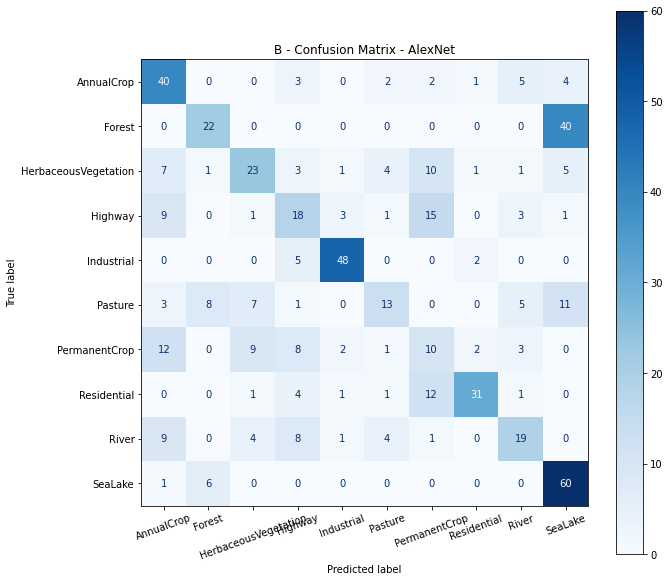

In [ ]:
classes = ['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake']
plot_confusion_matrix(labels, pred_labels, classes)

### Write results to csv

In [ ]:
resultsdf.to_csv('AlexNet.csv')
top1_5.to_csv('top1_5.csv')

In [ ]:
from google.colab import files
files.download("AlexNet.csv")
files.download("top1_5.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>